In [566]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np

# visualize the osm objects within a chip

In [567]:
folder = '/opt/data/california-naip-chips/osm/'
files = os.listdir(folder)

file = np.random.choice(files)
z = gpd.read_parquet(f"{folder}/{file}")
z.explore()

## inspect and visualize the neighbours of a chip

In [568]:
folder = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours"
files = os.listdir(folder)
file = np.random.choice(files)
file

'ca_m_3311705_nw_11_060_20220512-2-1.parquet'

In [569]:
z = pd.read_parquet(f"{folder}/{file}")
z

,chipid,lonm,latm,embeddings,distance
27,ca_m_3311704_ne_11_060_20220512-27-0,1.882734e+06,704186.394536,"[-0.11884993, 0.030776193, 0.117678, -0.008651...",1947.445580
28,ca_m_3311704_ne_11_060_20220512-28-0,1.882888e+06,704185.302735,"[-0.14079991, 0.026238035, 0.11230437, -0.0084...",1794.528601
29,ca_m_3311704_ne_11_060_20220512-29-0,1.883041e+06,704184.210891,"[-0.14211316, 0.029649517, 0.11832111, -0.0156...",1641.750436
30,ca_m_3311704_ne_11_060_20220512-30-0,1.883195e+06,704183.119003,"[-0.13085355, 0.032768942, 0.117722265, -0.012...",1489.153816
31,ca_m_3311704_ne_11_060_20220512-31-0,1.883348e+06,704182.027071,"[-0.13796024, 0.037063554, 0.09488666, -0.0100...",1336.800924
...,...,...,...,...,...
1875,ca_m_3411760_se_11_060_20220507-35-46,1.883998e+06,704041.752808,"[-0.13750143, 0.022531765, 0.13558123, 0.02611...",675.175795
1876,ca_m_3411760_se_11_060_20220507-36-46,1.884152e+06,704040.660625,"[-0.16637711, 0.018537715, 0.14854658, 0.02667...",522.018655
1877,ca_m_3411760_se_11_060_20220507-37-46,1.884305e+06,704039.568399,"[-0.14694682, 0.029659597, 0.13343862, 0.01800...",369.280075
1878,ca_m_3411760_se_11_060_20220507-38-46,1.884459e+06,704038.476130,"[-0.145391, 0.030405303, 0.1303312, 0.00235302...",217.842312


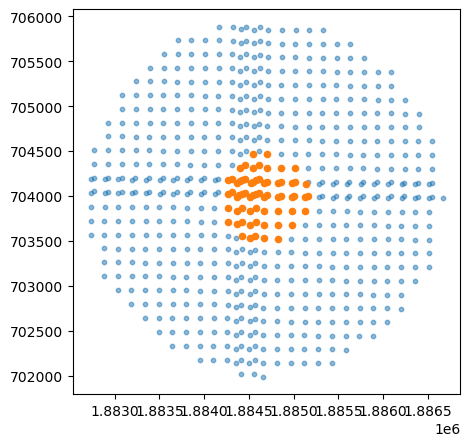

In [570]:
plt.figure(figsize=(5,5));
plt.scatter(z.lonm.values, z.latm.values, alpha=.5, s=10);
zz = z[z.distance<500]
plt.scatter(zz.lonm.values, zz.latm.values, s=20);

---

# Deduplicate the grid of neighbours

In [572]:
# Compute all pair-wise distances. Needed to find the average distance to a neighbor (exluding duplicates).

_center = z[z['distance'] == 0][['lonm', 'latm']].values[0]
z[['lonm', 'latm']] -= _center

n = z.shape[0]
X = z[['lonm', 'latm']].values  # coordinates
# distance matrix
XXt = X@X.T
L2 = np.diag(XXt)  # vector of squared lengths
_1_L2 = np.tile(L2, (n, 1))
L2_1 = _1_L2.T
D = np.sqrt(_1_L2 + L2_1 - 2*XXt)  # distance matrix

# find the pairs with distance smaller than 150m

D_triu = np.triu(D)

i_nodes = np.unique(np.concatenate(np.nonzero((1 < D_triu) & (D_triu < 150))))

[153.39427399 154.31293519]
153.85360458922128


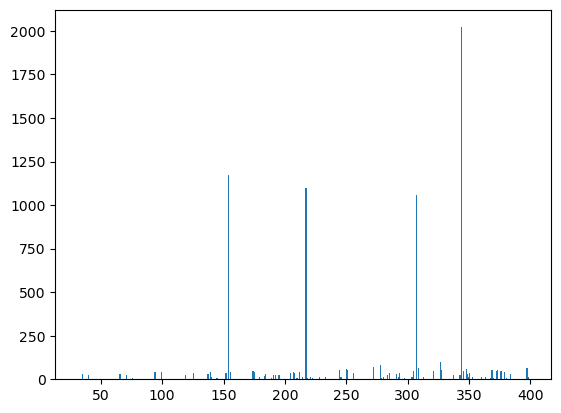

In [573]:
# histogram of distances
counts, binedges, _ = plt.hist(D_triu[(400 > D_triu) & (D_triu > 0)], bins=400);

i_bin = np.nonzero(counts > 500)[0][0]
edges = binedges[i_bin:i_bin + 2]
dist_nb = edges.mean()
print(edges)
print(dist_nb)

In [574]:
# # Highlight pairs with small distances (< dist_nb)

# plt.figure(figsize=(10,10));
# plt.scatter(X[:,0], X[:,1], alpha=.5, s=10);
# zz = X[i_nodes]
# plt.scatter(zz[:,0], zz[:,1], s=20);
# bin_edges = np.arange(-13.5, 14.5, 1) * dist_nb
# for _edge in bin_edges:
#     plt.axvline(_edge, c='gray', alpha=.3)
#     plt.axhline(_edge, c='gray', alpha=.3)
# plt.xlim(bin_edges.min(), bin_edges.max())
# plt.ylim(bin_edges.min(), bin_edges.max())

# # ID pairs
# # IX = np.stack(np.nonzero((1 < D_triu) & (D_triu < 150)), axis=1)
# print(IX.shape)

#### Histogram on the same edges

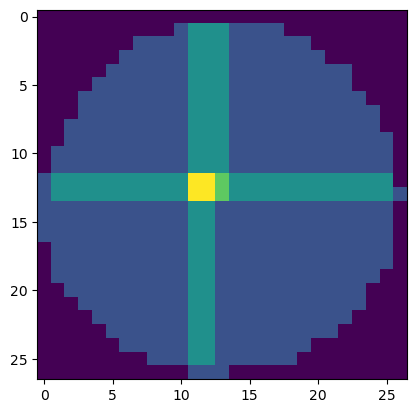

In [575]:
h, _xedges, _yedges = np.histogram2d(X[:,0], X[:,1], bins=(bin_edges, bin_edges));
plt.imshow(np.rot90(h));

In [576]:
ixbin = np.digitize(X[:,0], bin_edges) - 1
iybin = np.digitize(X[:,1], bin_edges) - 1
ibin = np.stack([ixbin, iybin], axis=1)  # grid indices of all chips
# ixbin = np.clip(ixbin, 0, h.shape[0]-1)
# iybin = np.clip(iybin, 0, h.shape[1]-1)
c = h[ixbin, iybin]

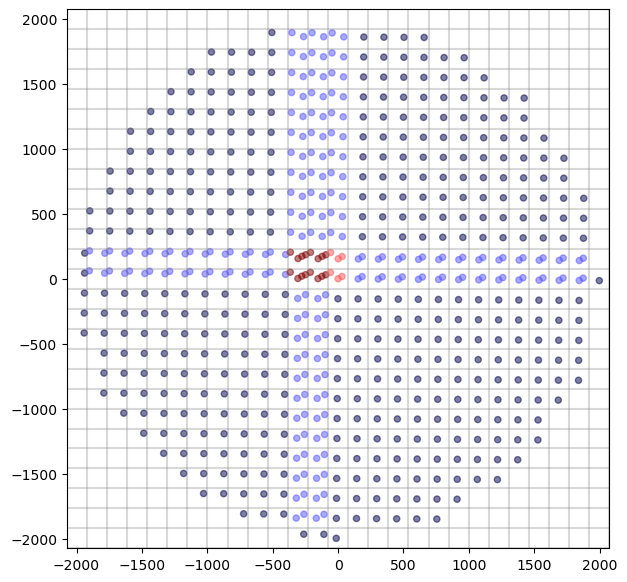

In [577]:
# Highlight grid-cells with more than one chip

plt.figure(figsize=(7,7));
plt.scatter(X[:,0], X[:,1], c=c, alpha=.5, s=20, cmap='seismic');
for _edge in bin_edges:
    plt.axvline(_edge, c='gray', alpha=.3)
    plt.axhline(_edge, c='gray', alpha=.3)
plt.xlim(bin_edges.min(), bin_edges.max());
plt.ylim(bin_edges.min(), bin_edges.max());

In [578]:
# remove excess chips, from cells with high count (>1)

_, unique_indices, unique_counts = np.unique(ibin, axis=0, return_index=True, return_counts=True)

In [579]:
# plt.scatter((X[:,0] % dist_nb), (X[:,1] % dist_nb), s=1);

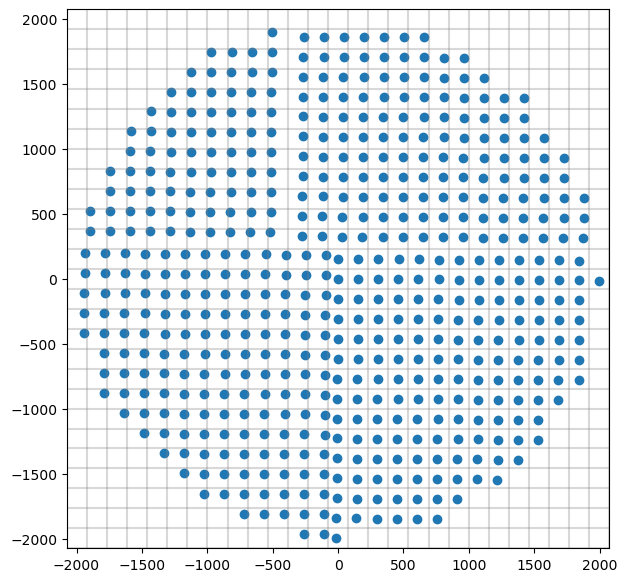

In [580]:
# De-duplicated neighborhood 

plt.figure(figsize=(7,7));
plt.scatter(X[unique_indices,0], X[unique_indices,1])#, alpha=.5, s=30, cmap='seismic');
for _edge in bin_edges:
    plt.axvline(_edge, c='gray', alpha=.3)
    plt.axhline(_edge, c='gray', alpha=.3)
plt.xlim(bin_edges.min(), bin_edges.max());
plt.ylim(bin_edges.min(), bin_edges.max());

---

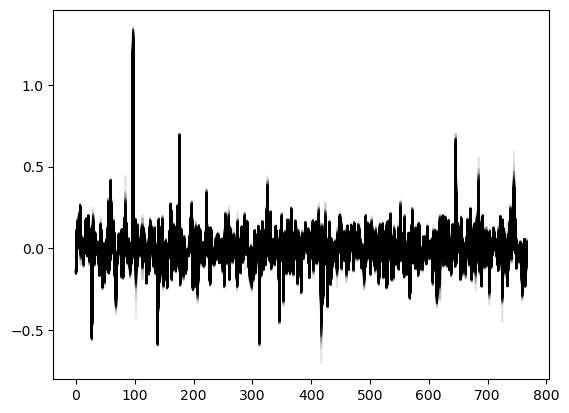

In [14]:
import matplotlib.pyplot as plt
for i in az[z.distance>1500].embeddings.values:
    plt.plot(i, color="black", alpha=.1)

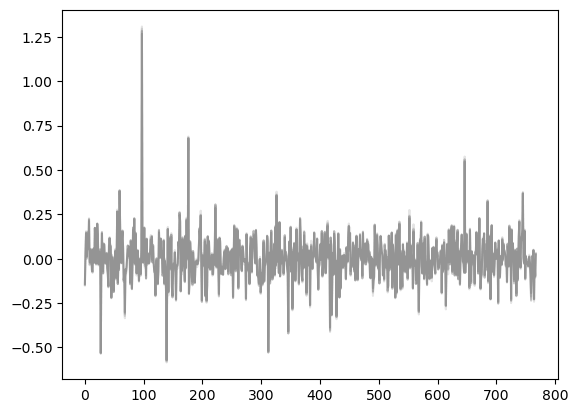

In [15]:
import matplotlib.pyplot as plt
for i in z[z.distance<200].embeddings.values:
    plt.plot(i, color="black", alpha=.1)

In [54]:
a = np.r_[6,3,3,6]
(a / 6).mean()


0.75

In [53]:
m  = np.array([[1, -1, -1, -1],
               [1, 1,  1, -1],
               [1, -1,  1, -1],
               [1, -1, -1, -1],
               [1,  1,  -1, -1],
               [1, 1,  1, -1 ]])
m

array([[ 1, -1, -1, -1],
       [ 1,  1,  1, -1],
       [ 1, -1,  1, -1],
       [ 1, -1, -1, -1],
       [ 1,  1, -1, -1],
       [ 1,  1,  1, -1]])

In [55]:
X = np.array([[1, 5, 1, 4, 8],
              [9, 7, 0, 7, 9],
              [0, 6, 3, 0, 6]])
v = np.array([9, 7, 0, 7, 9])

In [58]:
np.linalg.norm(X-v, axis=1)

array([ 8.88819442,  0.        , 12.20655562])